# Progetto AFMD
Caccaro Sebastiano - Cavagnino Matteo

### Download and extraction
The database is imported via the kaggle API token. They API key is needed in order to obtain access to kaggle. In the final py file, the upload part must be scrapped.

https://www.kaggle.com/general/74235


In [1]:
! pip install -q kaggle

from google.colab import files
print("Please upload your kaggle API Key")

keyname = "kaggle.json"
!rm $keyname
file = files.upload()
filename = list(file.keys())[0]
! mkdir ~/.kaggle
! mv $filename ~/.kaggle/$keyname
! chmod 600 ~/.kaggle/$keyname

Please upload your kaggle API Key
rm: cannot remove 'kaggle.json': No such file or directory


Saving seba_api_key.json to seba_api_key.json


Dataset Download

In [2]:
!kaggle datasets download -d baltacifatih/turkish-lira-banknote-dataset

100% 3.49G/3.50G [01:03<00:00, 56.5MB/s]
100% 3.50G/3.50G [01:03<00:00, 59.3MB/s]


Dataset Extraction

In [3]:
%%capture
!mkdir dataset
!unzip turkish-lira-banknote-dataset.zip -d dataset
!rm turkish-lira-banknote-dataset.zip

### Images import
Importing the images with tensorflow. All the the reference is taken from the following links

https://www.tensorflow.org/tutorials/load_data/images

In [4]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

from IPython.display import clear_output, display
from tensorflow.keras import datasets, layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tqdm import tqdm
import random
import math


tf.__version__

'2.2.0'

In [5]:
BATCH_SIZE = 32

# DO NOT MODIFY
ORIGINAL_HEIGHT = 720
ORIGINAL_WIDTH = 1280

#DO MODIFY
SCALE_FACTOR = 5

IMG_HEIGHT = math.floor(ORIGINAL_HEIGHT/SCALE_FACTOR)
IMG_WIDTH = math.floor(ORIGINAL_WIDTH/SCALE_FACTOR)

# Create a dictionary describing the features.  
image_feature_description = {
    'label' : tf.io.FixedLenFeature([6, ], tf.int64),
    'encoded': tf.io.FixedLenFeature([], tf.string),
}

In [6]:
data_dir = pathlib.Path("/content/dataset")
data_dir.lstat()
image_count = len(list(data_dir.glob('*/*.png')))
print ("Number of dataset images: " + str(image_count))

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name not in ["train.txt","validation.txt"]])
print ("Labels :" + str(CLASS_NAMES))

Number of dataset images: 6000
Labels :['20' '100' '50' '200' '10' '5']


Image Resizing

In [7]:
def resizeAndSave(imgPath):
  im = Image.open(imgPath)
  im = im.resize((IMG_WIDTH,IMG_HEIGHT))
  im.save(imgPath,"PNG")

all_images = list(data_dir.glob('*/*.png'))
all_images = [str(path) for path in all_images]
for path in tqdm(all_images):
  resizeAndSave(path)


random.shuffle(all_images)
 
image_count = len(all_images)

100%|██████████| 6000/6000 [04:05<00:00, 24.40it/s]


Separate training and validation images paths

In [8]:
training_ds = np.array(['./dataset/'+ item.rstrip() for item in open("./dataset/train.txt", 'r')])
validation_ds = np.array(['./dataset/' + item.rstrip() for item in open("./dataset/validation.txt", 'r')])
num_train = len(training_ds)
num_val = len(validation_ds)

Preprocessing functions

In [9]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES


def _process_image(path):
  image = open(path, 'rb').read()
  label= get_label(path)

  return image,label

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  """Wrapper for inserting bytes features into Example proto."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image_buffer, label):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.

  feature = {
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=label)),
      'encoded': _bytes_feature(tf.compat.as_bytes(image_buffer))
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()


def prepare_for_training(ds, cache=True, shuffle_buffer_size=num_train):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.batch(BATCH_SIZE,drop_remainder=True)

  ds = ds.repeat()

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def prepare_for_validation(dataset,cache=True):
    if cache:
      if isinstance(cache, str):
        dataset = dataset.cache(cache)
      else:
        dataset = dataset.cache()

    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  img = tf.cast(img, tf.float32)
  img /= 255.0
  return img 

import io
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  feature = tf.io.parse_single_example(example_proto, image_feature_description)
  #return tf.io.parse_single_example(example_proto, image_feature_description)
  image = feature["encoded"]
  image = decode_img(image)

  label = feature['label']


  return image, label

### Serialization

In [10]:
with tf.io.TFRecordWriter('training.tfrecords') as writer:
  for filename in tqdm(iterable=training_ds, desc='creating training tfrecords'):
    image_buffer,label = _process_image(filename)
    example = serialize_example(image_buffer, label)
    writer.write(example)
    os.remove(filename)
    
with tf.io.TFRecordWriter('validation.tfrecords') as writer:
  for filename in tqdm(iterable=validation_ds, desc='creating validation tfrecords'):
    image_buffer,label = _process_image(filename)
    example = serialize_example(image_buffer, label)
    writer.write(example)
    os.remove(filename)


creating validation tfrecords: 100%|██████████| 450/450 [00:02<00:00, 157.63it/s]


In [11]:
!rm -rf dataset

### Training

In [12]:
training_dataset = tf.data.TFRecordDataset(['training.tfrecords'])
validation_dataset = tf.data.TFRecordDataset(['validation.tfrecords'])

In [13]:
train_ds = training_dataset.map(_parse_image_function,num_parallel_calls=AUTOTUNE)
validation_ds = validation_dataset.map(_parse_image_function, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds,cache=False)
validation_ds = prepare_for_validation(validation_ds,cache=False)

Model callbacks


In [14]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, size, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = size//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)

Models definitions

In [15]:
def model_1():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=5, kernel_size=5, strides=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(len(CLASS_NAMES),activation="softmax"))
  model.summary()
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
 
  plot_training = PlotTraining(5550, sample_rate=10, zoom=5)
  history = None

  train_steps = int(num_train/BATCH_SIZE)
  validation_steps = int(num_val /BATCH_SIZE)

  EPOCHS = 20

  history = model.fit(x=train_ds,
                      validation_data=validation_ds,
                      validation_steps=validation_steps,
                      epochs=EPOCHS, 
                      steps_per_epoch=train_steps,
                      callbacks=[plot_training]
                      )

In [16]:
def model_2():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=5, kernel_size=5, strides=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH, 3), padding='same'))
  model.add(layers.Conv2D(filters=8, kernel_size=5, strides=2, activation='relu', padding='same'))
  model.add(layers.Conv2D(filters=12, kernel_size=3, strides=1, activation='relu'))
  model.add(layers.Conv2D(filters=15, kernel_size=3, strides=1, activation='relu'))
  model.add(layers.Conv2D(filters=18, kernel_size=3, strides=1, activation='relu')) 
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(len(CLASS_NAMES),activation="softmax")) 
  model.summary()
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  plot_training = PlotTraining(5550, sample_rate=10, zoom=5)
  history = None

  train_steps = int(num_train/BATCH_SIZE)
  validation_steps = int(num_val /BATCH_SIZE)

  EPOCHS = 20

  history = model.fit(x=train_ds,
                      validation_data=validation_ds,
                      validation_steps=validation_steps,
                      epochs=EPOCHS, 
                      steps_per_epoch=train_steps,
                      callbacks=[plot_training]
                      )

In [17]:
def model_3():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=5, kernel_size=5, strides=1, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=8, kernel_size=5, strides=1, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=12, kernel_size=3, strides=1, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=15, kernel_size=3, strides=1, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=18, kernel_size=3,strides=1, activation='relu', padding='same'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(len(CLASS_NAMES), activation="softmax"))
  model.summary()
  plot_training = PlotTraining(5550, sample_rate=10, zoom=5)
  history = None
 
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  train_steps = int(num_train/BATCH_SIZE)
  validation_steps = int(num_val /BATCH_SIZE)

  EPOCHS = 20

  history = model.fit(x=train_ds,
                      validation_data=validation_ds,
                      validation_steps=validation_steps,
                      epochs=EPOCHS, 
                      steps_per_epoch=train_steps,
                      callbacks=[plot_training]
                      )

In [18]:
def model_4():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=5, kernel_size=5, strides=1, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=8, kernel_size=5, strides=1, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=12, kernel_size=3,strides=1, activation='relu',  padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=15, kernel_size=3, strides=1, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(filters=18, kernel_size=3,strides=1, activation='relu', padding='same'))
  model.add(layers.Dropout(.075))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(.075))
  model.add(layers.Dense(len(CLASS_NAMES), activation="softmax"))
  model.summary()
 
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  plot_training = PlotTraining(5550, sample_rate=10, zoom=5)
  history = None

  train_steps = int(num_train/BATCH_SIZE)
  validation_steps = int(num_val /BATCH_SIZE)

  EPOCHS = 20

  history = model.fit(x=train_ds,
                      validation_data=validation_ds,
                      validation_steps=validation_steps,
                      epochs=EPOCHS, 
                      steps_per_epoch=train_steps,
                      callbacks=[plot_training]
                      )

In [19]:


def model_5():  
  plot_training = PlotTraining(5550, sample_rate=10, zoom=5)
  model = models.Sequential()
  model.add(layers.Conv2D(filters=5, kernel_size=5, strides=1, use_bias=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.BatchNormalization(center=True, scale=False))
  tf.keras.layers.Activation('relu')

  model.add(layers.Conv2D(filters=8, kernel_size=5, strides=1, use_bias=False, padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.BatchNormalization(center=True, scale=False))
  tf.keras.layers.Activation('relu')

  model.add(layers.Conv2D(filters=12, kernel_size=3, strides=1, use_bias=False,  padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.BatchNormalization(center=True, scale=False))
  tf.keras.layers.Activation('relu')

  model.add(layers.Conv2D(filters=15, kernel_size=3, strides=1, use_bias=False, padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.BatchNormalization(center=True, scale=False))
  tf.keras.layers.Activation('relu')
  model.add(layers.Dropout(0.06))

  model.add(layers.Conv2D(filters=18, kernel_size=3, strides=1, use_bias=False, padding='same'))
  
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization(center=True, scale=False))
  tf.keras.layers.Activation('relu')

  model.add(layers.Dense(64,use_bias=False))
  model.add(layers.BatchNormalization(center=True, scale=False))
  tf.keras.layers.Activation('relu')
  model.add(layers.Dropout(0.06))

  model.add(layers.Dense(len(CLASS_NAMES), activation="softmax"))
  model.summary()


  history = None
  opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  train_steps = int(num_train/BATCH_SIZE)
  validation_steps = int(num_val /BATCH_SIZE)

  EPOCHS = 50 

  history = model.fit(x=train_ds,
                      validation_data=validation_ds,
                      validation_steps=validation_steps,
                      epochs=EPOCHS, 
                      steps_per_epoch=train_steps,
                      callbacks=[plot_training]
                      )

Models execution

###Model 1

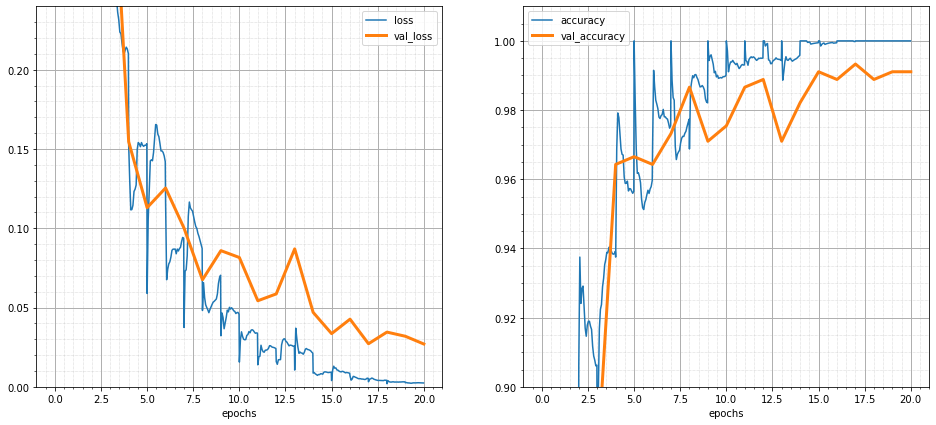

173/173 [==============================] - 4s 25ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 0.9911


In [20]:
model_1()

###Model 2

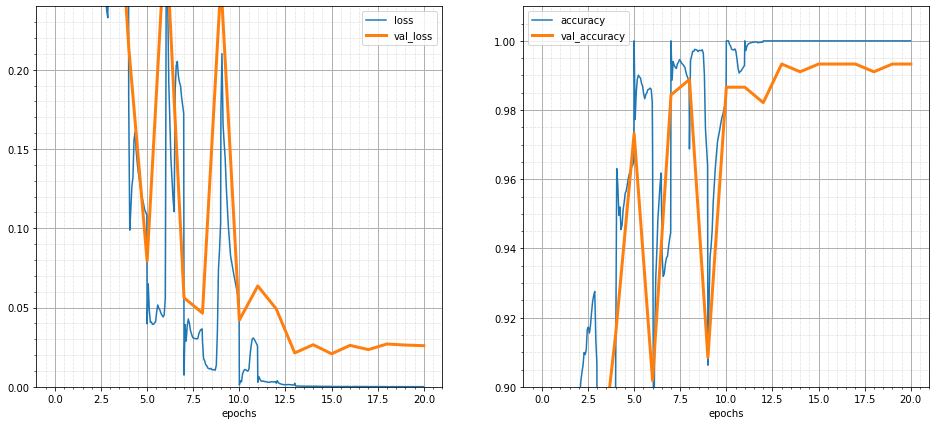

173/173 [==============================] - 4s 25ms/step - loss: 8.2015e-05 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9933


In [21]:
model_2()

###Model 3

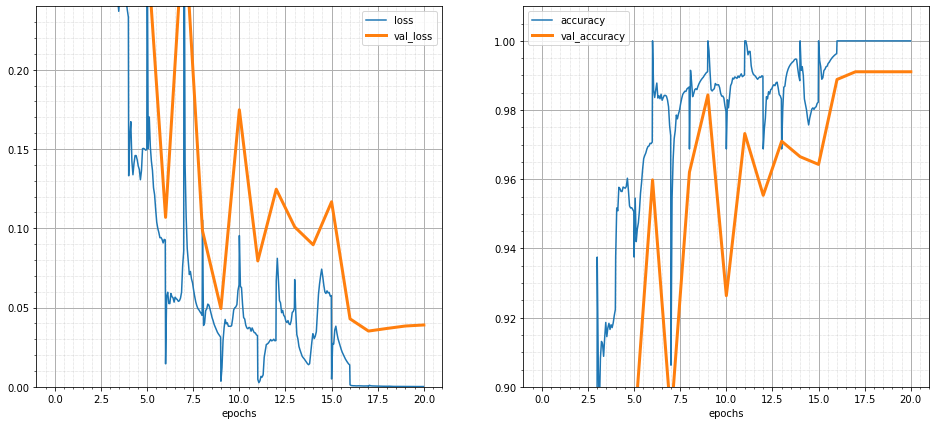

173/173 [==============================] - 6s 33ms/step - loss: 1.6085e-04 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 0.9911


In [22]:
model_3()

###Model 4

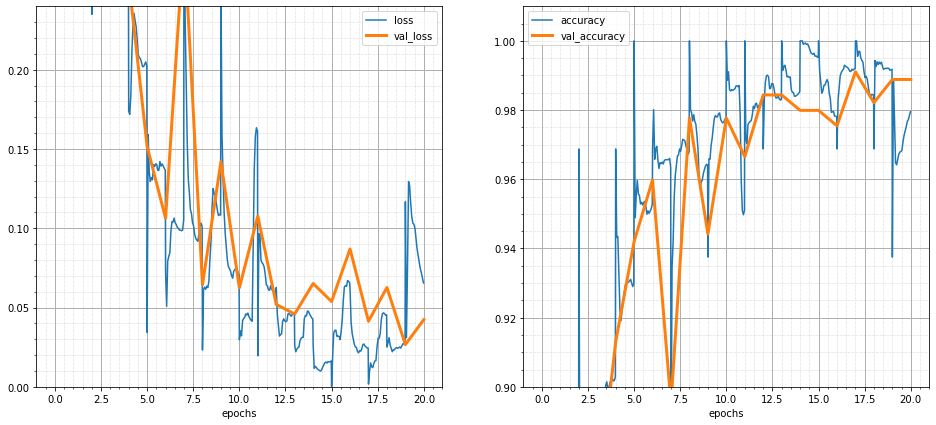

173/173 [==============================] - 6s 32ms/step - loss: 0.0648 - accuracy: 0.9798 - val_loss: 0.0424 - val_accuracy: 0.9888


In [23]:
model_4()

###Model 5

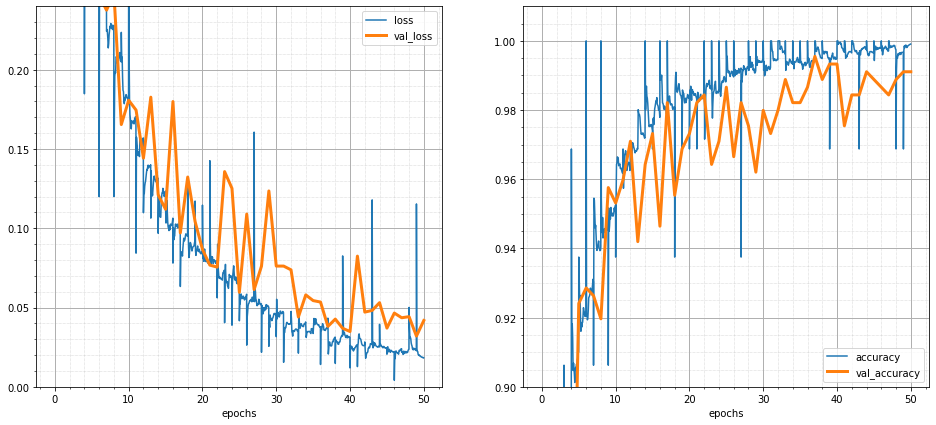

173/173 [==============================] - 5s 31ms/step - loss: 0.0186 - accuracy: 0.9989 - val_loss: 0.0418 - val_accuracy: 0.9911


In [24]:
model_5()